<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/VAE_with_auxiliary_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple template for the Variational Autoencoder Model (VAE):

https://arxiv.org/pdf/1312.6114.pdf

https://arxiv.org/pdf/1907.04809.pdf (iVAE)

https://github.com/ilkhem/iVAE

In [0]:
#Step 1: import dependencies
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import regularizers
import time
from __future__ import division

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline
plt.style.use('dark_background')

import pandas as pd

In [0]:
df1 = pd.read_csv("dge.txt",delimiter="\t")
df2 = pd.read_csv("geometry.txt",delimiter="\t")

In [4]:
df1['sna'].to_numpy()

array([0.111794, 0.221231, 0.159118, ..., 0.746477, 0.893983, 0.009584])

In [0]:
X = df1.to_numpy()

In [0]:
U = df2.to_numpy()
U = U[0:X.shape[0],:]

In [0]:
U_temp = []
for i in range(X.shape[0]):
  ss = U[i][0]
  ff = np.fromstring(ss, dtype=float, sep=' ')
  U_temp.append(ff)

U = np.array(U_temp)
U = U/np.max(np.abs(U), axis=0)

In [8]:
U.shape

(3039, 3)

In [9]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

configure_plotly_browser_state()

init_notebook_mode(connected=False)


import plotly.graph_objs as go


trace1 = go.Scatter3d(
    x=U[:,0],
    y=U[:,1],
    z=U[:,2],
    name = 'train data: line',
    mode='markers',
    marker=dict(
        size=3.0,
        color=df1['eve'].to_numpy(),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)


data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)



fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')

In [0]:
#Multivariate diagional
def create_encoder(x, latent_size):
  act = tf.nn.leaky_relu
  x = tf.layers.dense(x,84, act) 
  x = tf.layers.dense(x,42, act)
  x = tf.layers.dense(x,42, act)
  x = tf.layers.dense(x,42, act)
  x = tf.layers.dense(x,21, act)
  x = tf.layers.dense(x,10, act)
  x = tf.layers.dense(x,8, act)
  loc = tf.layers.dense(x,latent_size)
#   log_variance = tf.layers.dense(x, latent_size)
#   scale = tf.nn.softplus(log_variance)
  scale = 0.1*tf.ones(tf.shape(loc))
  return tfd.MultivariateNormalDiag(loc, scale)

def create_prior(latent_size, u):
  act = tf.nn.leaky_relu
  u = tf.layers.dense(u, 32, act)
  u = tf.layers.dense(u, 32, act)
  u = tf.layers.dense(u, 32, act)
  loc = tf.layers.dense(u, latent_size)
#   log_variance = tf.layers.dense(u, latent_size)
#   scale = tf.nn.softplus(log_variance)
  scale = 0.1*tf.ones(tf.shape(loc))
  return tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale), loc

def create_decoder(x, output_size):
  act = tf.nn.leaky_relu
  x = tf.layers.dense(x, 8, act)
  x = tf.layers.dense(x, 12, act)
  x = tf.layers.dense(x, 24, act)
  x = tf.layers.dense(x, 48, act)
  x = tf.layers.dense(x, 62, act)
  x = tf.layers.dense(x, 62, act)
  loc = tf.layers.dense(x, output_size)
  return loc

In [32]:
X.shape

(3039, 84)

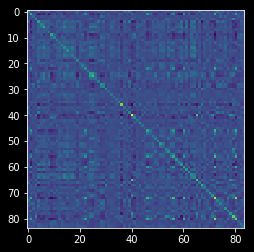

In [33]:
plt.imshow(np.cov(X.T))

In [0]:
#Connect encoder and decoder and define the loss function
tf.reset_default_graph()

x_in = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_in')
x_out = tf.placeholder(tf.float32, shape=[None, X.shape[1]], name='x_out')
u_in = tf.placeholder(tf.float32, shape=[None, 3], name='u_in')
u = u_in
x = tf.concat((x_in, u), axis=-1)

latent_size = 2

latent_prior, prior_loc = create_prior(latent_size, u)
latent_posterior = create_encoder(x, latent_size=latent_size)

latent_sampled = latent_posterior.sample()
latent_mean = latent_posterior.mean()

posterior_loc = create_decoder(latent_sampled, X.shape[1])


rec_loss = tf.losses.mean_squared_error(x_out, posterior_loc)
#rec_loss = tf.math.reduce_mean(tf.math.abs(x_out-posterior_loc))

#kl = tf.reduce_mean(tfd.kl_divergence(latent_posterior, latent_prior)) #analytical
kl = tf.reduce_mean(latent_posterior.log_prob(latent_sampled)- latent_prior.log_prob(latent_sampled)) #approximate KL
#beta=1e-3
beta = tf.placeholder(tf.float32, shape=[], name='beta')
kl_loss = beta*kl


loss = rec_loss + kl_loss
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

In [0]:
#Helper function
def batch_generator(features, x, u, batch_size):
  """Function to create python generator to shuffle and split features into batches along the first dimension."""
  idx = np.arange(features.shape[0])
  np.random.shuffle(idx)
  for start_idx in range(0, features.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, features.shape[0])
    part = idx[start_idx:end_idx]
    yield features[part,:], x[part,:] , u[part, :]

In [16]:
X.shape

(3039, 84)

In [35]:
n_epochs = 10000
batch_size = X.shape[0]
start = time.time()
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(n_epochs):
    beta0 = 1e-3
    gen = batch_generator(X, X, U, batch_size) #create batch generator
    total_loss = 0
    total_rec_loss = 0
    for j in range(np.int(X.shape[0]/batch_size)):
      x_in_batch, x_out_batch, u_batch = gen.__next__()
      _, total_loss_, total_rec_loss_= sess.run([optimizer, loss, rec_loss], feed_dict={x_in: x_in_batch, x_out: x_out_batch, u_in: u_batch, beta: beta0})
      total_loss += total_loss_
      total_rec_loss += total_rec_loss_
    if (i+1)% 10 == 0 or i == 0:
      latent_mean_, latent_sampled_, posterior_loc_, prior_loc_= sess.run([latent_mean, latent_sampled, posterior_loc, prior_loc], feed_dict ={x_in:X, x_out:X, u_in:U})
      end = time.time()
      print('epoch: {0}, total_loss: {1:.4f}, rec_loss: {2:.4f}, time: {3:.3f}'.format((i+1), 
                                       total_loss/(1+np.int(X.shape[0]/batch_size)), total_rec_loss/(1+np.int(X.shape[0]/batch_size)), end-start))
      start = time.time()

epoch: 1, total_loss: 0.0566, rec_loss: 0.0552, time: 0.562
epoch: 10, total_loss: 0.0487, rec_loss: 0.0484, time: 0.128
epoch: 20, total_loss: 0.0321, rec_loss: 0.0314, time: 0.138
epoch: 30, total_loss: 0.0229, rec_loss: 0.0224, time: 0.137
epoch: 40, total_loss: 0.0190, rec_loss: 0.0189, time: 0.146
epoch: 50, total_loss: 0.0184, rec_loss: 0.0183, time: 0.150
epoch: 60, total_loss: 0.0181, rec_loss: 0.0181, time: 0.138
epoch: 70, total_loss: 0.0180, rec_loss: 0.0179, time: 0.147
epoch: 80, total_loss: 0.0179, rec_loss: 0.0178, time: 0.135
epoch: 90, total_loss: 0.0177, rec_loss: 0.0177, time: 0.140
epoch: 100, total_loss: 0.0176, rec_loss: 0.0175, time: 0.140
epoch: 110, total_loss: 0.0173, rec_loss: 0.0173, time: 0.132
epoch: 120, total_loss: 0.0171, rec_loss: 0.0170, time: 0.137
epoch: 130, total_loss: 0.0168, rec_loss: 0.0168, time: 0.134
epoch: 140, total_loss: 0.0166, rec_loss: 0.0165, time: 0.145
epoch: 150, total_loss: 0.0164, rec_loss: 0.0163, time: 0.139
epoch: 160, total_l

Text(0, 0.5, 'z2')

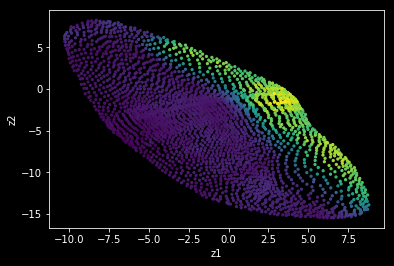

In [36]:
plt.scatter(latent_mean_[:,0],latent_mean_[:,1], c=df1['sna'].to_numpy(), cmap='viridis', s=5.0);
plt.xlabel('z1')
plt.ylabel('z2')

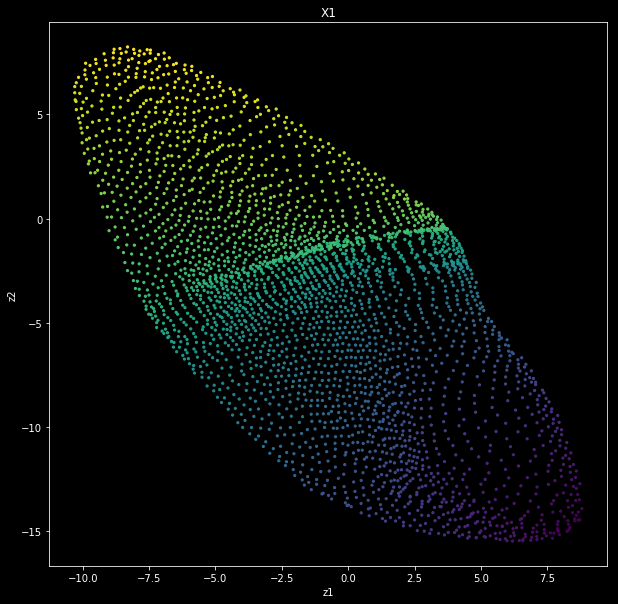

In [37]:
plt.figure(figsize=(10.0, 10.0));
plt.scatter(latent_mean_[:,0], latent_mean_[:,1], c=U[:,0], cmap='viridis', s=5.0);
plt.xlabel('z1');
plt.ylabel('z2');
plt.title('X1');

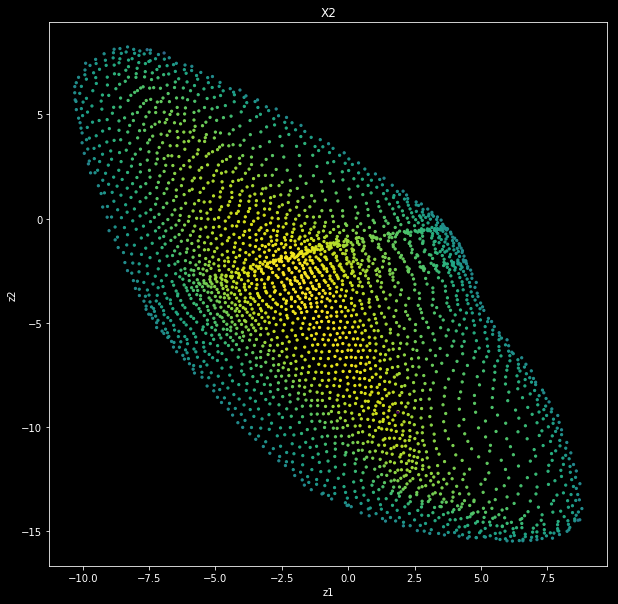

In [38]:
plt.figure(figsize=(10.0, 10.0));
plt.scatter(latent_mean_[:,0], latent_mean_[:,1], c=U[:,1], cmap='viridis', s=5.0);
plt.xlabel('z1');
plt.ylabel('z2');
plt.title('X2');

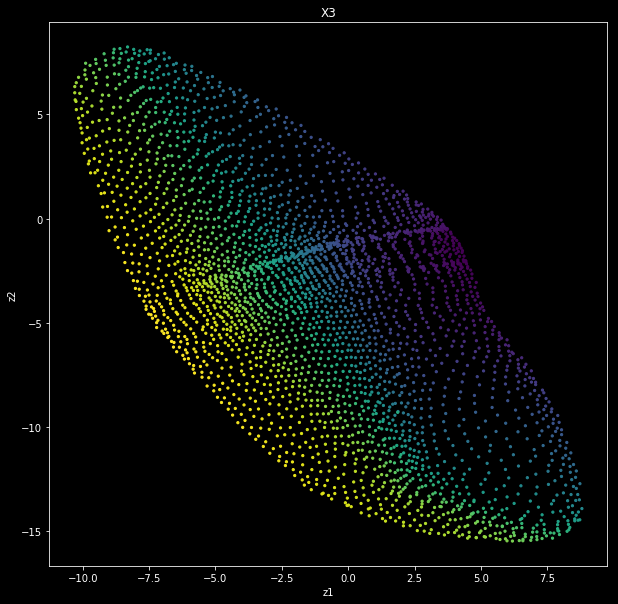

In [39]:
plt.figure(figsize=(10.0, 10.0));
plt.scatter(latent_mean_[:,0], latent_mean_[:,1], c=U[:,2], cmap='viridis', s=5.0);
plt.xlabel('z1');
plt.ylabel('z2');
plt.title('X3');

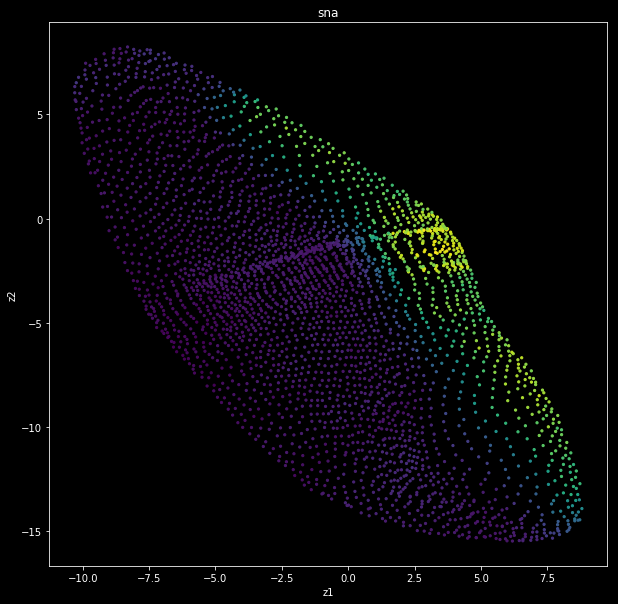

In [40]:
plt.figure(figsize=(10.0, 10.0));
plt.scatter(latent_mean_[:,0], latent_mean_[:,1], c=df1['sna'].to_numpy(), cmap='viridis', s=5.0);
plt.xlabel('z1');
plt.ylabel('z2');
plt.title('sna');

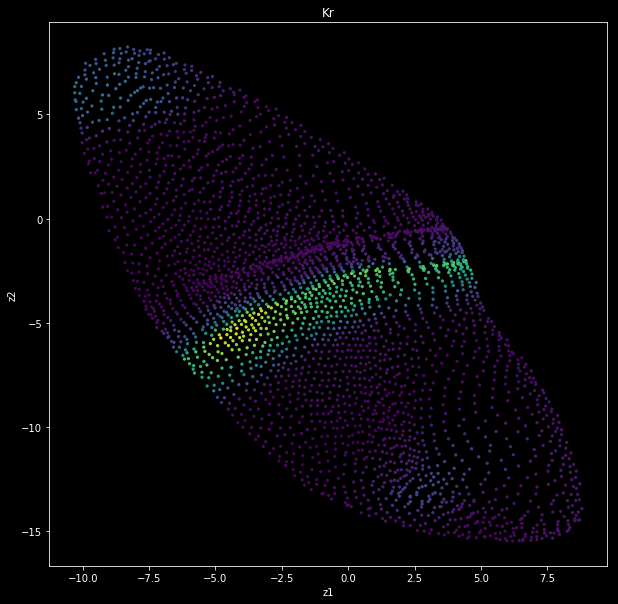

In [41]:
plt.figure(figsize=(10.0, 10.0));
plt.scatter(latent_mean_[:,0], latent_mean_[:,1], c=df1['Kr'].to_numpy(), cmap='viridis', s=5.0);
plt.xlabel('z1');
plt.ylabel('z2');
plt.title('Kr');

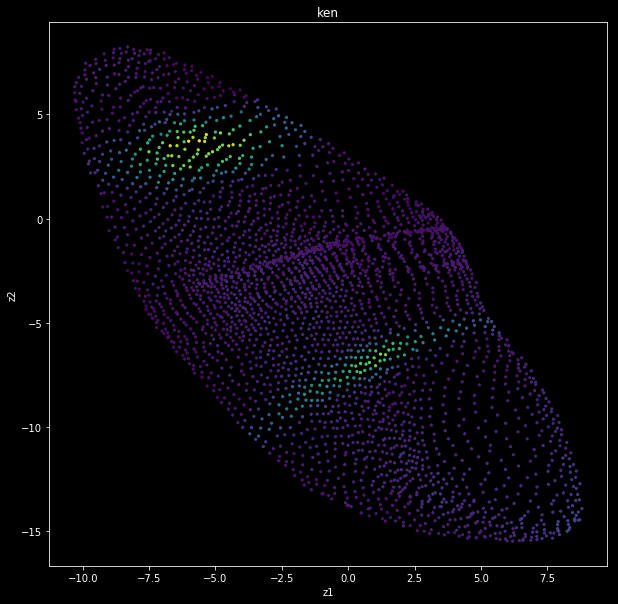

In [42]:
plt.figure(figsize=(10.0, 10.0));
plt.scatter(latent_mean_[:,0], latent_mean_[:,1], c=df1['ken'].to_numpy(), cmap='viridis', s=5.0);
plt.xlabel('z1');
plt.ylabel('z2');
plt.title('ken');

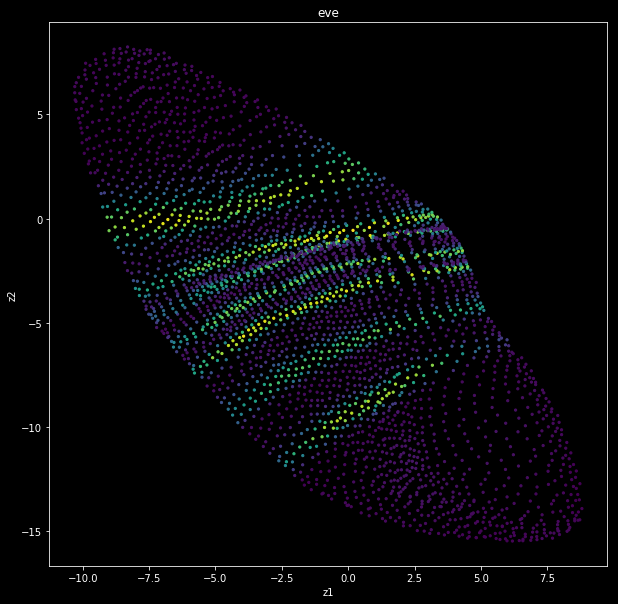

In [43]:
plt.figure(figsize=(10.0, 10.0));
plt.scatter(latent_mean_[:,0], latent_mean_[:,1], c=df1['eve'].to_numpy(), cmap='viridis', s=5.0);
plt.xlabel('z1');
plt.ylabel('z2');
plt.title('eve');